# Experimenting with Matrix Factorization and the MovieLens Dataset

This notebook will allow you to experiment with the parameters of matrix factorization with the MovieLens dataset. I'm using the 100k dataset, and storing it in a sparse matrix. 

In [8]:
import numpy as np
from scipy.sparse import lil_matrix
import time
import matplotlib.pyplot as plt
%matplotlib inline

data_file = 'ml-100k/u.data'
data_file = open(data_file,'r')
users,movies = list(),list()

for line in data_file.readlines():
    line = line.split()
    user = int(line[0])
    movie = int(line[1])
    users.append(user)
    movies.append(movie)

users = np.unique(users)
movies = np.unique(movies)

user_to_id = dict(zip(users,range(len(users))))
movie_to_id = dict(zip(movies,range(len(movies))))
id_to_user = dict(zip(range(len(users)),users))
id_to_movie = dict(zip(range(len(movies)),movies))

data = lil_matrix((len(users),len(movies)))

data_file = 'ml-100k/u.data'
data_file = open(data_file,'r')
for line in data_file.readlines():
    line = line.split()
    user = user_to_id[int(line[0])]
    movie = movie_to_id[int(line[1])]
    rating = int(line[2])
    data[user,movie] = rating

## Parameters to optimize:

- K = number of latent features
- lr = learning rate
- error_threshold = absolute point you're willing to have as an error on your values
    (A threshold of 0.5 means you think getting a rating wrong by 0.5 points is acceptable.)
- split = proportion of the data you'll use for training
- max_time = a variation of max_iters (number of seconds the loop is allowed to run for)

I use the mean absolute error as the error can be positive or negative, and the absolute value is easier to visualize (especially when it falls under 1). 


Mean absolute error at iteration 0: (time = 0.00021648406982421875 )
	Train: 1.1502740827877342 	Test: 1.1174685447291224

Mean absolute error at iteration 1: (time = 2.8906171321868896 )
	Train: 0.8356673785187446 	Test: 0.9749240077854258

Mean absolute error at iteration 2: (time = 5.773926258087158 )
	Train: 0.7580980825156028 	Test: 1.0060422095201536

Mean absolute error at iteration 3: (time = 8.65103554725647 )
	Train: 0.7303988534832467 	Test: 1.0281589875762553

Mean absolute error at iteration 4: (time = 11.52914810180664 )
	Train: 0.7084978739980411 	Test: 1.0498538255061958

Mean absolute error at iteration 5: (time = 14.409475088119507 )
	Train: 0.6877904755875945 	Test: 1.0719458115337939

Mean absolute error at iteration 6: (time = 17.28250217437744 )
	Train: 0.668900864993239 	Test: 1.0937200914547707

Mean absolute error at iteration 7: (time = 20.170579433441162 )
	Train: 0.6524422420148088 	Test: 1.1150677324202174

Mean absolute error at iteration 8: (time = 23.26

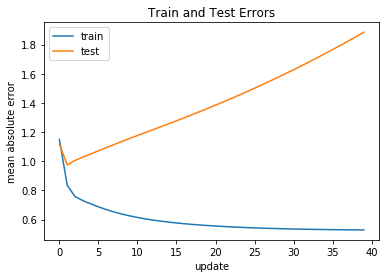

In [20]:
n = len(users)
m = len(movies)
K = 15
lr = .01
error_threshold = .1
split = .7
max_time = 120

# matrices used for factorization initialized randomly
p = np.random.rand(n,K)
q = np.random.rand(m,K)

# entries = cells that contain a value in our data matrix
entries = list(zip(*data.nonzero()))
train_entries = entries[:int(len(entries)*split)]
test_entries = entries[int(len(entries)*split):]

def mean_absolute_error(r,p,q,local_entries):
    error = 0
    for (i,j) in local_entries:
        current_error = r[i,j]
        for k in range(K): current_error -= p[i,k]*q[j,k]
        error += abs(current_error)
    return error/len(local_entries)

error_train = mean_absolute_error(data,p,q,train_entries)
error_test = mean_absolute_error(data,p,q,test_entries)
train_errors = [error_train]
test_errors = [error_test]
iter=0
start = time.time()
while error_train > error_threshold and time.time()-start<max_time:
    print('\nMean absolute error at iteration',str(iter)+': (time =',time.time()-start,')') 
    print('\tTrain:',error_train,'\tTest:',error_test)
    iter+=1
    for (i,j) in train_entries: 
        local_error = data[i,j] - sum([p[i,k]*q[j,k] for k in range(K)])
        for k in range(K):
            # updating equations = derivatives of the error per parameter
            p[i,k] += 2*lr*local_error*q[j,k]
            q[j,k] += 2*lr*local_error*p[i,k]
    error_train = mean_absolute_error(data,p,q,train_entries)
    error_test = mean_absolute_error(data,p,q,test_entries)
    train_errors.append(error_train)
    test_errors.append(error_test)
    
    
#################################################
################ PLOTTING ERRORS ################
#################################################

x = range(len(train_errors))
plt.plot(x,train_errors,label='train')
plt.plot(x,test_errors,label='test')
plt.legend()
plt.title('Train and Test Errors')
plt.xlabel('update')
plt.ylabel('mean absolute error')
plt.show()